# Машинное обучение, ВМК МГУ

## Практическое задание 2

### Общая информация
Дата выдачи: 23.03.2019

Мягкий дедлайн: 23:59MSK 07.04.2019
Жёсткий дедлайн: 23:59MSK 14.04.2019

### О задании

Мы будем решать задачу предсказания опасных событий для страховой компании: [Liberty Mutual Group: Property Inspection Prediction](https://www.kaggle.com/c/liberty-mutual-group-property-inspection-prediction). Обучающая выборка состоит из засекреченных признаков целого и строкового типов. Целевой переменной являются счётчики $y \in \mathbb{Z}_+$.

Работа состоит из следующих пунктов:
* Предобработать данные [1 балл]
* Написать свой алгоритм прогнозирования событий [2 балла]
* Настроить линейные методы из библиотеки StatsModels для решения задачи [1 балл]
* Настроить бустинг из библиотеки lightgbm для решения задачи [1 балл]

Задания является дополнительным, то есть само по себе не учитывается в накопленной оценке. Все полученные за задание баллы являются бонусными, то есть их можно прибавить к оценке за любое теоретическое или практическое домашнее задание из курса.


### Оценивание и штрафы
Каждая из задач имеет определенную «стоимость» (указана в скобках около задачи). Максимально допустимая оценка за работу — 5 баллов.

Сдавать задание после указанного срока сдачи нельзя. При выставлении неполного балла за задание в связи с наличием ошибок на усмотрение проверяющего предусмотрена возможность исправить работу на указанных в ответном письме условиях.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов (подробнее о плагиате см. на странице курса). Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

Неэффективная реализация кода может негативно отразиться на оценке.


### Формат сдачи
Для сдачи задания переименуйте получившийся файл *.ipynb в соответствии со следующим форматом: homework-practice-06-Username.ipynb, где Username — ваша фамилия и имя на латинице именно в таком порядке (например, homework-practice-06-IvanovIvan.ipynb). 

Далее отправьте этот файл в AnyTask.

Для удобства проверки самостоятельно посчитайте свою максимальную оценку (исходя из набора решенных задач) и укажите ниже.

**Оценка:** 5 (10? Я сделал всё, но сумма баллов в ноутбуке только 5)

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm

from scipy.optimize import minimize
from lightgbm import LGBMModel
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.model_selection import train_test_split

pd.set_option('max_rows', 10)
pd.set_option('max_columns', None)
plt.style.use('bmh')

%matplotlib inline

__Задание 1 (1 балл).__ Загрузка и предобработка данных.

In [4]:
data = pd.read_csv('data.csv', index_col='Id')
data.head()

,Hazard,T1_V1,T1_V2,T1_V3,T1_V4,T1_V5,T1_V6,T1_V7,T1_V8,T1_V9,T1_V10,T1_V11,T1_V12,T1_V13,T1_V14,T1_V15,T1_V16,T1_V17,T2_V1,T2_V2,T2_V3,T2_V4,T2_V5,T2_V6,T2_V7,T2_V8,T2_V9,T2_V10,T2_V11,T2_V12,T2_V13,T2_V14,T2_V15
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,1,15,3,2,N,B,N,B,B,D,7,B,B,15,1,A,B,N,36,11,N,10,B,2,37,1,11,6,Y,N,E,2,2
2,4,16,14,5,H,B,N,B,B,C,12,B,B,10,3,A,B,Y,78,10,Y,17,C,2,22,1,18,5,Y,Y,E,2,1
3,1,10,10,5,N,K,N,B,B,E,12,H,B,15,1,A,R,Y,71,21,Y,13,C,6,37,2,14,6,Y,Y,E,6,1
4,1,18,18,5,N,K,N,B,B,E,3,H,B,15,1,A,R,N,71,13,N,15,A,2,25,1,1,6,Y,N,C,2,6
5,1,13,19,5,N,H,N,B,B,E,7,H,B,10,1,A,J,N,75,10,Y,11,B,1,22,1,2,7,N,N,E,1,1


In [5]:
data.shape

(50964, 33)

Выделим категориальные и числовые признаки:

In [6]:
categorical, numerical = list(), list()
for col in data.columns[1:]:
    if isinstance(data.loc[1, col], str):
        categorical.append(col)
    if isinstance(data.loc[1, col], np.int64):
        numerical.append(col)

In [16]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    print(data[categorical].nunique(), '\n')
    print(data[numerical].nunique())

T1_V4      8
T1_V5     10
T1_V6      2
T1_V7      4
T1_V8      4
T1_V9      6
T1_V11    12
T1_V12     4
T1_V15     8
T1_V16    18
T1_V17     2
T2_V3      2
T2_V5      6
T2_V11     2
T2_V12     2
T2_V13     5
dtype: int64 

T1_V1      19
T1_V2      24
T1_V3       9
T1_V10      5
T1_V13      4
T1_V14      5
T2_V1     100
T2_V2      39
T2_V4      22
T2_V6       7
T2_V7       7
T2_V8       3
T2_V9      25
T2_V10      7
T2_V14      7
T2_V15     12
dtype: int64


In [20]:
data['T1_V6'].unique(), data['T1_V17'].unique(), data['T2_V3'].unique(), data['T2_V11'].unique(), data['T2_V12'].unique()

(array(['N', 'Y'], dtype=object),
 array(['N', 'Y'], dtype=object),
 array(['N', 'Y'], dtype=object),
 array(['Y', 'N'], dtype=object),
 array(['N', 'Y'], dtype=object))

In [22]:
for col in categorical:
    print(sorted(data[col].unique()))

['B', 'C', 'E', 'G', 'H', 'N', 'S', 'W']
['A', 'B', 'C', 'D', 'E', 'H', 'I', 'J', 'K', 'L']
['N', 'Y']
['A', 'B', 'C', 'D']
['A', 'B', 'C', 'D']
['B', 'C', 'D', 'E', 'F', 'G']
['A', 'B', 'D', 'E', 'F', 'H', 'I', 'J', 'K', 'L', 'M', 'N']
['A', 'B', 'C', 'D']
['A', 'C', 'D', 'F', 'H', 'N', 'S', 'W']
['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R']
['N', 'Y']
['N', 'Y']
['A', 'B', 'C', 'D', 'E', 'F']
['N', 'Y']
['N', 'Y']
['A', 'B', 'C', 'D', 'E']


Нарисуем априорное распределение ответов $p(y)$:

c:\program files\python36\lib\site-packages\matplotlib\axes\_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


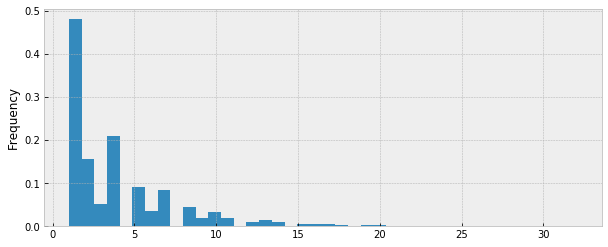

In [21]:
data['Hazard'].plot(kind='hist', figsize=(10, 4), bins=40, normed=True)
plt.show()

In [23]:
data['Hazard'].min()

1

В обобщённых линейных моделях, как и в машинном обучении в целом, мы проводим основную работу с апостериорным распределением $p(y|x)$, ведь именно в нём заключается информация о конкретной задаче. Здесь же мы знаем, что количество несчастных случаев во многом подчиняется распределению Пуассона, поэтому будем стараться моделировать именно его.

В выборке могут присутствовать шумовые признаки. Попробуем простейшим способом избавиться от них.

Исследуйте абсолютное значение корреляции:
* Признаков и отклика
* Признаков и логарифма отклика

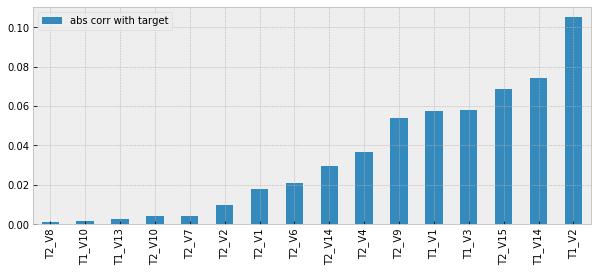

In [27]:
corrs = [data[col].corr(data['Hazard']) for col in numerical]
corrs = pd.DataFrame(np.abs(corrs), numerical, 
    ['abs corr with target']).sort_values('abs corr with target')
corrs.plot(kind='bar', figsize=(10, 4))
plt.show()

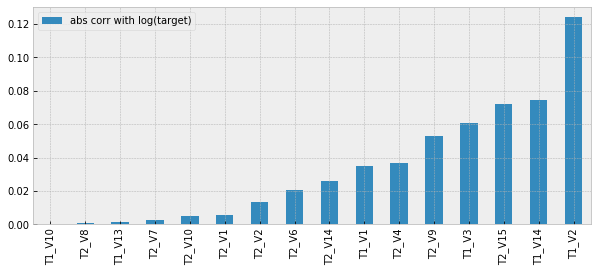

In [33]:
# corr with log(target)
# place your code here

log_target = np.log(data['Hazard'])

corrs_log = [data[col].corr(log_target) for col in numerical]
corrs_log = pd.DataFrame(np.abs(corrs_log), numerical, 
    ['abs corr with log(target)']).sort_values('abs corr with log(target)')
corrs_log.plot(kind='bar', figsize=(10, 4))
plt.show()

Уберите несколько наиболее неинформативных признаков. Лучше сделать это число гиперпараметром и потом настраивать его по функционалу качества. Может быть разумно также исследовать взаимосвязь признаков с логарифмом целевой переменной, поскольку мы предполагаем, что она неотрицательна и имеет распределение Пуассона.

In [71]:
# place your code here
data = data.drop(columns=corrs_log.index[:9])

Закодируем значения категориальных признаков в числа:

In [72]:
label_encoder = LabelEncoder()
data[categorical] = data[categorical].apply(label_encoder.fit_transform)

Выделим столбец целевой переменной из наших данных. Множество значений случайной величины с распределением Пуассона начинается с нуля $\{0, 1, 2...\}$, поэтому вычтем единицу из целевой переменной. На самом деле, помимо прочего это приводит к существенному росту качества на валидации.

In [73]:
objects = data.loc[:, 'T1_V1':]
labels = data['Hazard'] - 1

Сделаем бинарное кодирование категориальных признаков:

In [74]:
mask = objects.columns.isin(categorical)
onehot_encoder = OneHotEncoder(categorical_features=mask, sparse=False)
objects_encoded = onehot_encoder.fit_transform(objects)

c:\program files\python36\lib\site-packages\sklearn\preprocessing\_encoders.py:368: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)
c:\program files\python36\lib\site-packages\sklearn\preprocessing\_encoders.py:390: DeprecationWarning: The 'categorical_features' keyword is deprecated in version 0.20 and will be removed in 0.22. You can use the ColumnTransformer instead.
  "use the ColumnTransformer instead.", DeprecationWarning)


Разделим выборку на обучающую и тестовую:

In [75]:
train_objects, test_objects, train_labels, test_labels = train_test_split(
    objects_encoded, labels.as_matrix(), random_state=1, test_size=0.2, stratify=labels
)

c:\program files\python36\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


__Задание 2 (2 балла).__ Обучение регрессии с распределением Пуассона.

Будем считать, что апостериорное распределение — это распределение Пуассона:

$$p(y|\lambda(x)) = \frac{e^{-\lambda(x)}\lambda(x)^y}{y!}.$$

Реализуйте функции для вычисления функционала качества (через метод максимального правдоподобия) и его градиентов — они были выведены на [семинаре](https://github.com/esokolov/ml-course-hse/blob/master/2017-spring/seminars/sem22-glm.pdf).

Численные алгоритмы должны работать по возможности быстро, поэтому циклов быть не должно, и все операции должны быть векторными. Дальше мы будем использовать эту функцию в качестве аргумента другой функции. Можете попробовать добавить в модель регуляризатор.

In [108]:
def oracle(w, X, y):
    """
    :param w: weights
    :param X: features
    :param y: target
    :yield: loss, grad
    """
    
    # place your code here
    prod = np.matmul(X, w)
    exp_prod = np.exp(prod)
    loss = (exp_prod - y.dot(prod)).sum()
    grad = np.matmul(X.T, exp_prod - y)
    
    return loss, grad

Добавьте к признакам столбец единиц, чтобы учесть вектор сдвига. Это важно. Библиотечные алгоритмы уже учитывают это внутри себя, поэтому им на вход нужно подавать исходную выборку.

In [77]:
train_objects_bias = np.concatenate([train_objects, np.ones((train_objects.shape[0], 1))], axis=1)
test_objects_bias = np.concatenate([test_objects, np.ones((test_objects.shape[0], 1))], axis=1)

Дальше воспользуйтесь функцией _scipy.optimize.minimize_, в ней реализовано множество градиентных методов оптимизации. Рекомендуется взять [L-BFGS-B](http://www.machinelearning.ru/wiki/images/6/65/MOMO17_Seminar6.pdf). Начальное приближение весов $w^{(0)}$ возьмите из стандартного нормального распределения как _np.random.randn_. Возможно, придётся запустить функцию несколько раз, прежде чем начальное приближение окажется удачным, и алгоритм покажет хороший результат. 

Сделайте прогноз для тестовых объектов. В качестве прогноза мы будем брать матожидание распределения $p(y | \lambda(x))$ в данной точке, поэтому не забудьте взять экспоненту от выхода линейной модели, предсказывающей значение натурального параметра. Измерьте качество с помощью коэффициента Джини (чем выше – тем лучше) — именно он является целевой метрикой в соревновании.

In [78]:
def gini(y_true, y_pred):
    # check and get number of samples
    assert y_true.shape == y_pred.shape
    n_samples = y_true.shape[0]
    
    # sort rows on prediction column 
    # (from largest to smallest)
    arr = np.array([y_true, y_pred]).transpose()
    true_order = arr[arr[:,0].argsort()][::-1,0]
    pred_order = arr[arr[:,1].argsort()][::-1,0]
    
    # get Lorenz curves
    L_true = np.cumsum(true_order) / np.sum(true_order)
    L_pred = np.cumsum(pred_order) / np.sum(pred_order)
    L_ones = np.linspace(1/n_samples, 1, n_samples)
    
    # get Gini coefficients (area between curves)
    G_true = np.sum(L_ones - L_true)
    G_pred = np.sum(L_ones - L_pred)
    
    # normalize to true Gini coefficient
    return G_pred/G_true

In [91]:
# place your code here
poisson_results = minimize(oracle, np.random.randn(train_objects_bias.shape[1]), 
                           args=(train_objects_bias, train_labels), method='L-BFGS-B', jac=True) #change parameters
print(gini(test_labels, np.matmul(test_objects_bias, poisson_results.x)))
print(gini(test_labels, np.exp(np.matmul(test_objects_bias, poisson_results.x))))

0.13870490297992838
0.13870490297992838


**Ответ:** Модель очень нестабильна. Это - лучший результат, и повторить что-либо похожее не получилось после серии запусков.

__Задание 3 (1 балл).__ Линейные модели из коробки.

Запустите базовую линейную регрессию *sklearn.linear_model.LinearRegression* для предсказания логарифма целевой переменной и измерьте качество. Сравните полученный результат с работой вашего алгоритма.

In [130]:
# place your code here
lin_model1 = LinearRegression()
lin_model1.fit(train_objects, np.log(train_labels+1))

print(gini(test_labels, lin_model1.predict(test_objects)))
print(gini(test_labels, lin_model1.predict(test_objects)+1))
print(gini(test_labels, np.exp(lin_model1.predict(test_objects)+1)))

0.30831602830428023
0.30831602830428023
0.30831602830428023


Познакомимся теперь с библиотекой [StatsModels](http://www.statsmodels.org/dev/index.html). Она предназначена скорее для описательной статистики, проверки гипотез и построения доверительных интервалов, чем для прогнозирования, — в отличие от scikit-learn, который создан специально для решения задач машинного обучения. В то же время в StatsModels реализован очень сильный алгоритм прогнозирования временных рядов – [SARIMAX](http://www.statsmodels.org/dev/generated/statsmodels.tsa.statespace.sarimax.SARIMAX.html), который при правильной настройке работает очень хорошо и занимает первые места в конкурсах ([Запись трансляции ML тренировки 03.02.18 | TrainMyData Ascott](https://www.youtube.com/watch?v=9MQEEyYDCQc&t=1101s)). 

Мы же попробуем обучить обобщённые линейные модели (модуль [GLM](http://www.statsmodels.org/dev/glm.html)) с различными вероятностными распределениями. Запустите алгоритм _sm.GLM_ на нескольких распределениях family, посмотрите на качество и проинтерпретируйте результаты. Синтаксис StatsModels немного отличается от scikit-learn тем, что здесь объекты и метки задаются в конструкторе модели, метод _fit()_ идёт без аргументов, и после обучения сохраняется новая модель с результатами и методом _predict_.

__Gaussian__

In [132]:
#place your code here
gaussian_sm_model = sm.GLM(train_labels, train_objects, sm.families.Gaussian())
gaussian_sm_results = gaussian_sm_model.fit()
pred_labels = gaussian_sm_results.predict(test_objects)
gini(test_labels, pred_labels)

0.3051258909210555

__Poisson__

In [133]:
#place your code here
poisson_sm_model = sm.GLM(train_labels, train_objects, sm.families.Poisson())
poisson_sm_results = poisson_sm_model.fit()
pred_labels = poisson_sm_results.predict(test_objects)
gini(test_labels, pred_labels)

0.30788848748736525

__NegativeBinomial (Pascal)__

In [135]:
# place your code here
negbinom_sm_model = sm.GLM(train_labels, train_objects, sm.families.NegativeBinomial())
negbinom_sm_results = negbinom_sm_model.fit()
pred_labels = negbinom_sm_results.predict(test_objects)
gini(test_labels, pred_labels)

0.30881021410858545

Как видно, качество в последнем случае получилось лучше. На практике чаще используют именно отрицательное Биномиальное распределение. Оно является обобщением геометрического распределения и даёт некоторую свободу в выборе среднего и дисперсии для $p(y|x)$, тогда как в распределении Пуассона среднее и дисперсия совпадают. Если вам будет интересно, можете прочитать подробнее на вики [NegativeBinomial](https://en.m.wikipedia.org/wiki/Negative_binomial_distribution).

__Задание 4. (1 балл)__ Прогнозирование с помощью бустинга.

Что бы мы ни делали, бустинг по-прежнему остаётся лучшим подходом для широкого круга задач — особенно если мы не работаем со структурированными данными вроде последовательностей или картинок. Бустинг хоть и сложный по своей структуре алгоритм, но вероятностные распределения не чужды и ему. Запустите _LGBMModel_, используя классическую регрессию и регрессию Пуассона. Настройте параметры, чтобы добиться наилучшего качества. В особенности обратите внимание на *objective*, *n_estimators*, *num_leaves* и *colsample_bytree*.

In [137]:
# objective='regression'
lgbmmodel1 = LGBMModel(objective='regression')
lgbmmodel1.fit(train_objects, train_labels)
pred1 = lgbmmodel1.predict(test_objects)
print(gini(test_labels, pred1))

0.35214717140988644


In [138]:
# objective='poisson'
lgbmmodel2 = LGBMModel(objective='poisson')
lgbmmodel2.fit(train_objects, train_labels)
pred2 = lgbmmodel2.predict(test_objects)
print(gini(test_labels, pred2))

0.3555657417114342


In [143]:
from scipy import stats
from sklearn.model_selection import RandomizedSearchCV

In [151]:
def gini_scorer(estimator, X, y):
    return gini(y, estimator.predict(X))

In [163]:
%%time
params = {
    'objective': ['regression', 'poisson'],
    'num_leaves': range(12, 60),
    'colsample_bytree': stats.uniform(loc=0.1, scale=0.9),
    'learning_rate': stats.expon(scale=0.1),
    'reg_alpha': stats.expon(scale=1.0),
    'reg_lambda': stats.expon(scale=1.0)
}

lgbmmodel3 = LGBMModel()
rsearch = RandomizedSearchCV(lgbmmodel3, params, n_iter = 300, n_jobs=-1, cv=5, scoring=gini_scorer,
                            return_train_score=False)
rsearch.fit(train_objects, train_labels)
print(rsearch.cv_results_, '\n')
print(rsearch.best_params_)
print(rsearch.best_score_)
print(gini(test_labels, rsearch.best_estimator_.fit(train_objects, train_labels).predict(test_objects)))

{'mean_fit_time': array([1.57507939, 1.02192736, 0.90942349, 1.12818141, 0.92680235,
       1.30198507, 0.96567483, 0.98755007, 1.04380379, 1.87822027,
       0.99692574, 1.8032166 , 1.68133659, 0.9656745 , 1.12505713,
       0.77503948, 1.5407042 , 1.24068899, 1.20943694, 1.11880636,
       0.88129535, 1.88447199, 0.8344173 , 1.54070406, 1.32506857,
       1.01567731, 1.34069338, 1.69383683, 1.07505593, 0.90004368,
       1.59070554, 1.02817693, 1.78134284, 1.371946  , 1.03755403,
       1.20631146, 1.30944171, 1.06880517, 1.48132544, 1.55320539,
       1.06567979, 1.18756166, 1.04380302, 1.57195435, 1.61883245,
       1.09693012, 1.0531795 , 0.89692101, 1.02192826, 1.58758106,
       1.43132315, 1.18756008, 1.52195163, 1.95634985, 1.27193947,
       1.00317588, 0.96254969, 0.74691248, 1.08130536, 1.1813107 ,
       1.5094523 , 0.92504706, 1.32819357, 1.31256695, 1.41257071,
       1.27194042, 1.10630755, 1.30944095, 1.95009913, 2.06260543,
       1.09068356, 1.68133645, 1.44382305, 1

0.3575970711248538
Wall time: 4min 47s


In [166]:
lgbmmodel4 = LGBMModel(colsample_bytree=0.4298482718301969, learning_rate=0.014890822107759868, 
                       num_leaves=26, objective='poisson', reg_alpha=0.3274949775772318, reg_lambda=0.16460689292145095,
                      n_estimators=1000)
preds4 = lgbmmodel4.fit(train_objects, train_labels).predict(test_objects)
print(gini(test_labels, preds4))

0.3583996699587472


In [167]:
lgbmmodel5 = LGBMModel(colsample_bytree=0.4298482718301969, learning_rate=0.0014890822107759868, 
                       num_leaves=26, objective='poisson', reg_alpha=0.3274949775772318, reg_lambda=0.16460689292145095,
                      n_estimators=10000)
preds5 = lgbmmodel5.fit(train_objects, train_labels).predict(test_objects)
print(gini(test_labels, preds5))

0.3584930668791791


**Ответ:** модель, оптимизирующаяся с учётом распределения Пуассона, показала лучший результат как без подбора параметров, так и с ним.